In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('lenk_style')

# Data prep

### Import pollen data

https://www.allergialiit.ee/oietolmu-seire/

In [3]:
p16 = pd.read_csv('data/pollen_2016.csv', sep=';')
p17 = pd.read_csv('data/pollen_2017.csv', sep=';')
p18 = pd.read_csv('data/pollen_2018.csv', sep=';')
p19 = pd.read_csv('data/pollen_2019.csv', sep=';')
p20 = pd.read_csv('data/pollen_2020.csv', sep=';')
p21 = pd.read_csv('data/pollen_2021.csv', sep=';')

In [4]:
df_pollen = pd.concat([p16, p17, p18, p19, p20, p21])

In [5]:
df_pollen = df_pollen.rename(columns={'Kuupäev':'date', 'Lepp':'alder'})
df_pollen['date'] = pd.to_datetime(df_pollen['date'], format='%Y-%m-%d').dt.round('D')
df_pollen = df_pollen.dropna()
df_pollen = df_pollen.sort_values(by='date')
df_pollen = df_pollen.set_index('date')

In [6]:
df_pollen = df_pollen[['alder']].copy()
df_pollen['year'] = df_pollen.index.year
df_pollen['day'] = df_pollen.index.dayofyear
# including only March and April as those are the months with highest pollen levels
df_pollen = df_pollen.loc[(df_pollen.index.month>=3)&(df_pollen.index.month<=4)]
df_pollen.head()

,alder,year,day
date,,,
2016-03-01,12.0,2016,61
2016-03-02,14.0,2016,62
2016-03-03,2.0,2016,63
2016-03-04,5.0,2016,64
2016-03-05,4.0,2016,65


In [7]:
df_pollen[['alder']].describe()

,alder
count,362.000000
mean,56.450276
std,179.346008
min,0.000000
25%,1.000000
50%,6.000000
75%,32.250000
max,2171.000000


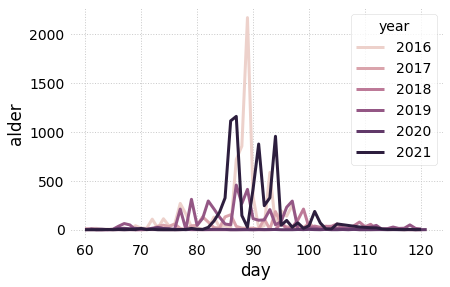

In [8]:
sns.lineplot(data=df_pollen, x='day', y='alder', hue='year')
plt.show()

### Import weather data

Weather data collection is in another notebook

In [9]:
df_weather = pd.read_csv('data/weather_data.csv', index_col='date')
df_weather.index = pd.to_datetime(df_weather.index, format='%d.%m.%Y')

In [10]:
for c in [c for c in df_weather.columns if 'okta' in c]:
    df_weather[c] = df_weather[c].str[-1].replace('-',0).astype(int)

### Prepare the data

In [11]:
df = df_pollen[['alder']].join(df_weather, how='left')

In [12]:
dummies = pd.get_dummies(df['Hetkeilm (sensor)'], drop_first=True)
df = df.join(dummies)
df = df.drop(columns=['Hetkeilm (sensor)'])

In [13]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

# Building the model

In [15]:
from xgboost import XGBRegressor

In [16]:
xgb = XGBRegressor()

### Cross-validation

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
scores = cross_val_score(estimator = xgb,
                         X = X_train,
                         y = y_train,
                         scoring = 'neg_mean_absolute_error',
                         cv = 10)

print(f'mean  {scores.mean():.2f}') # this is the MAE to beat
print(f'stdev  {scores.std():.2f}')

mean  -73.06
stdev  44.39


### Hyperparameter tuning

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
parameters = {
    'max_depth':[6, 7, 8],
    'min_child_weight':[4, 5, 6],
    'subsample':[.7, .8, .9],
    'colsample_bytree':[.6, .7, .8],
    'eta':[.005, .001],
    'objective':['reg:squarederror']
}

In [21]:
grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = parameters,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    n_jobs = -1
)

In [22]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'eta': [0.005,

In [23]:
print(f'Best MAE: {grid_search.best_score_:.2f}')
print('Best Parameters:', grid_search.best_params_)

Best MAE: -55.47
Best Parameters: {'colsample_bytree': 0.7, 'eta': 0.001, 'max_depth': 7, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'subsample': 0.8}


### Best model

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
best_model = XGBRegressor(
    objective = 'reg:squarederror',
    colsample_bytree = 0.7,
    eta = 0.001,
    max_depth = 7,
    min_child_weight = 5,
#     n_estimators = 500,
    subsample = 0.8
    )

best_model.fit(X_train, y_train, verbose=False)

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f'MAE {mae:.2f}')

MAE 51.03


# Results

In [26]:
d = pd.DataFrame(y_test)
d = d.sort_index()
d['prediction'] = y_pred
d['year'] = d.index.year
d['day'] = d.index.dayofyear

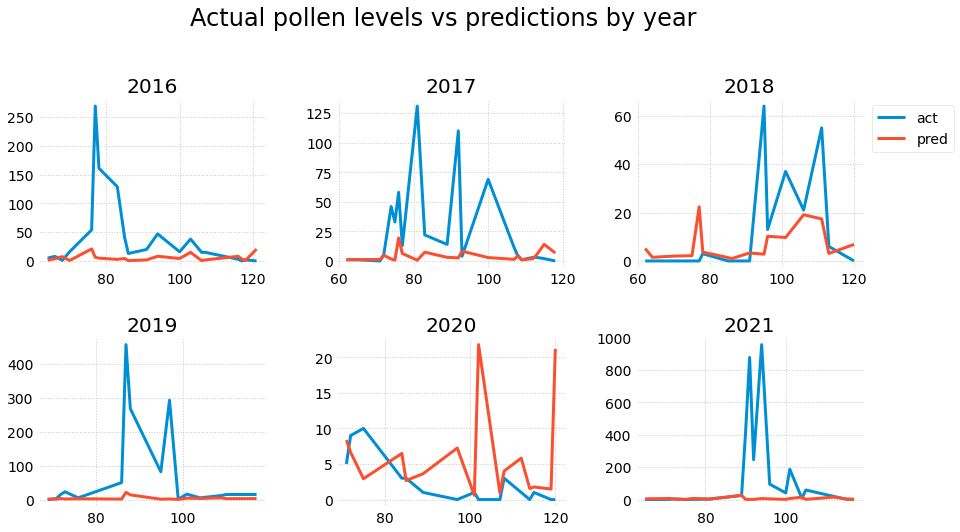

In [27]:
nrows, ncols = 2, 3
num_plots = nrows*ncols
fig = plt.figure(figsize=(12, 6))
axes = [plt.subplot(nrows,ncols,i) for i in range(1,num_plots+1)]

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.subplots_adjust(wspace=.3, hspace=.4)

cols = d['year'].unique()

for i, c in enumerate(cols):
    axes[i].plot(d.loc[str(c),'day'], d.loc[str(c),'alder'], label='act')
    axes[i].plot(d.loc[str(c),'day'], d.loc[str(c),'prediction'], label='pred')
    axes[i].set_title(c)
    
axes[2].legend(bbox_to_anchor=(1, 1))
        
fig.suptitle('Actual pollen levels vs predictions by year', y=1.2, size=24)

plt.savefig('predictions-by-year.png', bbox_inches='tight', dpi=100)

plt.show()

### Shap

In [28]:
import shap

In [29]:
df_x_train = pd.DataFrame(X_train, columns=X.columns)
shap_values = shap.TreeExplainer(best_model).shap_values(df_x_train)

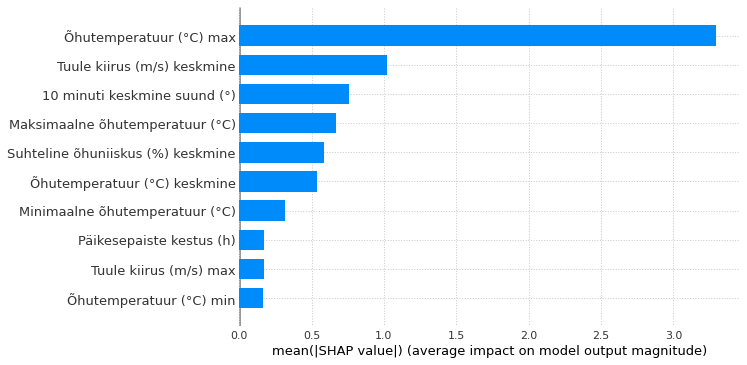

In [30]:
shap.summary_plot(shap_values, df_x_train, plot_type='bar', max_display=10)

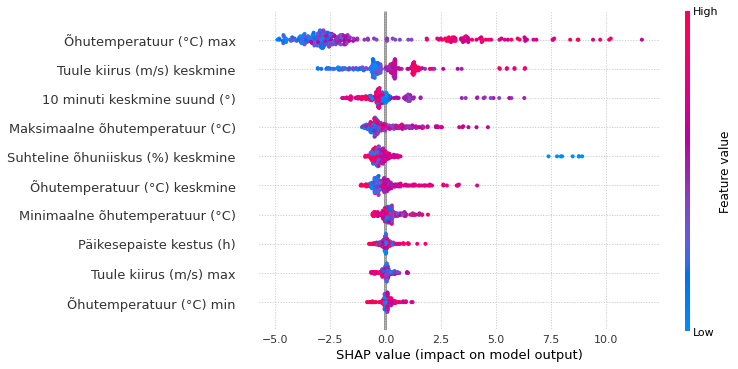

In [31]:
shap.summary_plot(shap_values, df_x_train, max_display=10)